In [1]:
# ===============================================
# 02_feature_engineering_and_diagnostics.ipynb
# Medical Cost Prediction — Feature Engineering & Diagnostics (Regression-only)
# ===============================================

# --- 1) Imports & Setup ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", rc={"figure.figsize": (7,4)})

from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.inspection import permutation_importance


from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
# --- 2) Load Data ---
df = pd.read_csv("../data/insurance.csv")
display(df.head())
print(df.shape, df.isna().sum())


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


(1338, 7) age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [3]:
# --- 3) Helper Metrics ---
def mape(y_true, y_pred):
    return 100*np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9)))

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

In [4]:
# --- 4) Manual Feature Engineering (domain-driven interactions) ---
df_fe = df.copy()
df_fe["smoker_int"] = (df_fe["smoker"] == "yes").astype(int)
df_fe["smoker_age"] = df_fe["smoker_int"] * df_fe["age"]
df_fe["smoker_bmi"] = df_fe["smoker_int"] * df_fe["bmi"]
df_fe["age_bmi"]    = df_fe["age"] * df_fe["bmi"]

target = "charges"
base_num = ["age","bmi","children"]
eng_num  = ["smoker_age","smoker_bmi","age_bmi"]
num_cols = base_num + eng_num
cat_cols = ["sex","smoker","region"]

X = df_fe.drop(columns=[target, "smoker_int"])
y = df_fe[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

num_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])
cat_transformer = OneHotEncoder(drop="first", handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols),
        ("cat", cat_transformer, cat_cols),
    ]
)

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)


In [5]:
# --- 5) Baseline & Linear Family (on engineered features) ---
pipe_base = Pipeline([("prep", preprocessor), ("model", DummyRegressor(strategy="mean"))])
base_cv = -cross_val_score(pipe_base, X_train, y_train, scoring="neg_root_mean_squared_error", cv=cv)
print(f"[Baseline] CV_RMSE: {base_cv.mean():.2f} ± {base_cv.std():.2f}")

models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(max_iter=20000, random_state=RANDOM_STATE),
    "ElasticNet": ElasticNet(max_iter=20000, random_state=RANDOM_STATE),
}
for name, est in models.items():
    pipe = Pipeline([("prep", preprocessor), ("model", est)])
    scores = -cross_val_score(pipe, X_train, y_train, scoring="neg_root_mean_squared_error", cv=cv)
    print(f"[{name:9s}] CV_RMSE: {scores.mean():.2f} ± {scores.std():.2f}")


[Baseline] CV_RMSE: 12017.19 ± 361.87
[Linear   ] CV_RMSE: 4897.71 ± 576.65
[Ridge    ] CV_RMSE: 4908.45 ± 571.60
[Lasso    ] CV_RMSE: 4897.48 ± 576.48
[ElasticNet] CV_RMSE: 6005.07 ± 426.45


In [6]:
# --- 6) Hyperparameter Tuning: ElasticNet (original target) ---
param_grid_en = {
    "model__alpha": np.logspace(-3, 2, 60),
    "model__l1_ratio": np.linspace(0.05, 0.95, 19),
}
pipe_en = Pipeline([
    ("prep", preprocessor),
    ("model", ElasticNet(max_iter=20000, random_state=RANDOM_STATE))
])
rs_en = RandomizedSearchCV(
    pipe_en,
    param_distributions=param_grid_en,
    n_iter=60,
    scoring="neg_root_mean_squared_error",
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=-1
).fit(X_train, y_train)
print("[EN-raw] Best params:", rs_en.best_params_, "| Best CV_RMSE:", -rs_en.best_score_)
best_en_raw = rs_en.best_estimator_
best_en_raw.fit(X_train, y_train)
pred_raw = best_en_raw.predict(X_test)

[EN-raw] Best params: {'model__l1_ratio': np.float64(0.95), 'model__alpha': np.float64(0.0026529484644318944)} | Best CV_RMSE: 4897.561738930957


In [7]:
y_train_log = np.log1p(y_train)
y_test_log  = np.log1p(y_test)

pipe_en_log = Pipeline([
    ("prep", preprocessor),
    ("model", ElasticNet(max_iter=20000, random_state=RANDOM_STATE))
])
rs_en_log = RandomizedSearchCV(
    pipe_en_log,
    param_distributions=param_grid_en,
    n_iter=60,
    scoring="neg_mean_squared_error", 
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=-1
).fit(X_train, y_train_log)
print("[EN-log] Best params:", rs_en_log.best_params_, "| Best CV_MSE(log):", -rs_en_log.best_score_)

best_en_log = rs_en_log.best_estimator_
best_en_log.fit(X_train, y_train_log)
pred_log_back = np.expm1(best_en_log.predict(X_test))  

[EN-log] Best params: {'model__l1_ratio': np.float64(0.25), 'model__alpha': np.float64(0.0012154742500762859)} | Best CV_MSE(log): 0.1553249648638749


In [8]:
# --- 8) Metrics (compare raw vs log) ---
def report_metrics(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    mp   = mape(y_true, y_pred)
    rl   = rmsle(y_true, y_pred)
    print(f"[{name}] RMSE: {rmse:.2f} | MAE: {mae:.2f} | R²: {r2:.3f} | MAPE: {mp:.2f}% | RMSLE: {rl:.4f}")
    return rmse, mae, r2, mp, rl

print("\n=== Test Metrics ===")
report_metrics("ElasticNet-RAW", y_test, pred_raw)
report_metrics("ElasticNet-LOG(back-trans)", y_test, pred_log_back)


=== Test Metrics ===
[ElasticNet-RAW] RMSE: 4564.22 | MAE: 2761.91 | R²: 0.866 | MAPE: 29.28% | RMSLE: 0.3938
[ElasticNet-LOG(back-trans)] RMSE: 5592.85 | MAE: 2639.72 | R²: 0.799 | MAPE: 18.39% | RMSLE: 0.3640


(np.float64(5592.845779300093),
 2639.723674497477,
 0.7985173623612354,
 np.float64(18.392487421812977),
 np.float64(0.3639622835394052))

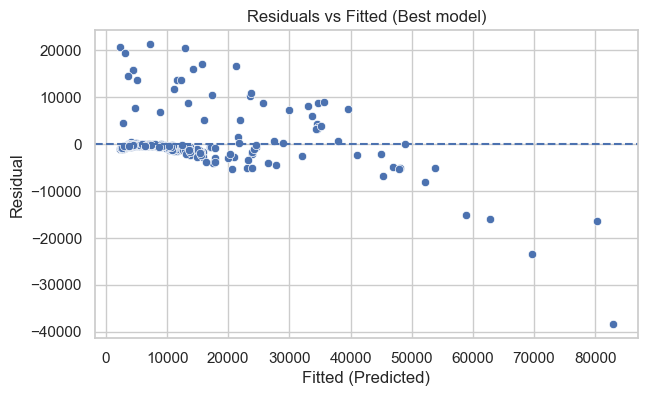

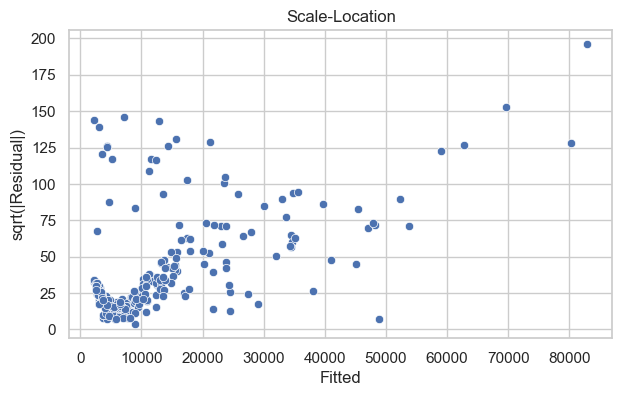

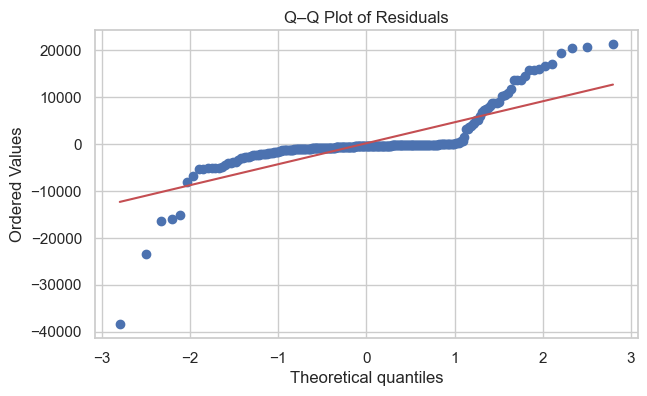

Normality test (D’Agostino): K2=68.88, p=1.1e-15
Breusch–Pagan: stat=76.89, p=5.88e-12

🔹 Error by Smoker


C:\Users\hasti_aksoy\AppData\Local\Temp\ipykernel_20984\1893666315.py:47: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = tmp.groupby(col).apply(lambda g: pd.Series({


,n,MAE,RMSE,MAPE%
smoker,,,,
yes,54.0,6133.325270,9131.632584,17.057205
no,214.0,1758.160655,4258.107754,18.729428


🔹 Error by Sex


C:\Users\hasti_aksoy\AppData\Local\Temp\ipykernel_20984\1893666315.py:47: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = tmp.groupby(col).apply(lambda g: pd.Series({


,n,MAE,RMSE,MAPE%
sex,,,,
male,128.0,2852.174105,6223.235340,20.927226
female,140.0,2445.483281,4946.680974,16.075013


🔹 Error by Region


C:\Users\hasti_aksoy\AppData\Local\Temp\ipykernel_20984\1893666315.py:47: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = tmp.groupby(col).apply(lambda g: pd.Series({


,n,MAE,RMSE,MAPE%
region,,,,
southeast,81.0,3078.725045,6633.679144,20.537747
northwest,69.0,2552.863149,5736.071528,16.995399
northeast,57.0,2835.656218,4729.678512,19.360118
southwest,61.0,1971.954991,4568.607051,16.219999


🔹 Error by Age group


C:\Users\hasti_aksoy\AppData\Local\Temp\ipykernel_20984\1893666315.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = tmp.groupby(col).apply(lambda g: pd.Series({
C:\Users\hasti_aksoy\AppData\Local\Temp\ipykernel_20984\1893666315.py:47: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = tmp.groupby(col).apply(lambda g: pd.Series({


,n,MAE,RMSE,MAPE%
age_bin,,,,
"(17, 30]",97.0,2569.465042,6201.476807,29.288056
"(50, 60]",48.0,3577.760474,6195.039957,16.076481
"(40, 50]",57.0,2539.296025,5230.599187,10.271344
"(30, 40]",48.0,1964.787363,4551.189950,10.411360
"(60, 80]",18.0,2634.759229,3776.254198,12.853462


In [ ]:
# --- 9) Residual Diagnostics (use best of the two) ---
y_pred_best = pred_log_back
res = y_test - y_pred_best
fitted = y_pred_best

# Residual plot
fig, ax = plt.subplots()
sns.scatterplot(x=fitted, y=res, ax=ax)
ax.axhline(0, ls="--")
ax.set_xlabel("Fitted (Predicted)")
ax.set_ylabel("Residual")
ax.set_title("Residuals vs Fitted (Best model)")
plt.show()

# Scale-Location: sqrt(|residuals|)
fig, ax = plt.subplots()
sns.scatterplot(x=fitted, y=np.sqrt(np.abs(res)), ax=ax)
ax.set_xlabel("Fitted")
ax.set_ylabel("sqrt(|Residual|)")
ax.set_title("Scale-Location")
plt.show()

# Q-Q plot 
fig = sm.QuantReg 
fig = plt.figure()
ax = fig.add_subplot(111)
stats.probplot(res, dist="norm", plot=ax)
ax.set_title("Q–Q Plot of Residuals")
plt.show()


k2, p_norm = stats.normaltest(res)
print(f"Normality test (D’Agostino): K2={k2:.2f}, p={p_norm:.3g}")

# Breusch–Pagan for heteroskedasticity

X_test_trans = best_en_log.named_steps["prep"].transform(X_test)
X_test_trans = sm.add_constant(X_test_trans, has_constant='add')
bp_stat, bp_p, _, _ = het_breuschpagan(res, X_test_trans)
print(f"Breusch–Pagan: stat={bp_stat:.2f}, p={bp_p:.3g}")



In [11]:
# --- 10) Subgroup Errors (fairness/robustness audit) ---
from sklearn.metrics import mean_squared_error as MSE

def subgroup_errors(dfX, y_true, y_pred, col):
    tmp = pd.DataFrame({"y_true": y_true, "y_pred": y_pred, col: dfX[col].values})
    out = tmp.groupby(col).apply(lambda g: pd.Series({
        "n": len(g),
        "MAE": mean_absolute_error(g["y_true"], g["y_pred"]),
        "RMSE": np.sqrt(mean_squared_error(g["y_true"], g["y_pred"])),
        "MAPE%": mape(g["y_true"], g["y_pred"])
    })).sort_values("RMSE", ascending=False)
    return out

print("\n🔹 Error by Smoker")
display(subgroup_errors(X_test, y_test, y_pred_best, "smoker"))

print("🔹 Error by Sex")
display(subgroup_errors(X_test, y_test, y_pred_best, "sex"))

print("🔹 Error by Region")
display(subgroup_errors(X_test, y_test, y_pred_best, "region"))

X_test_bins = X_test.copy()
X_test_bins["age_bin"] = pd.cut(X_test_bins["age"], bins=[17,30,40,50,60,80])
print("🔹 Error by Age group")
display(subgroup_errors(X_test_bins, y_test, y_pred_best, "age_bin"))


🔹 Error by Smoker


C:\Users\hasti_aksoy\AppData\Local\Temp\ipykernel_20984\3013565742.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = tmp.groupby(col).apply(lambda g: pd.Series({


,n,MAE,RMSE,MAPE%
smoker,,,,
yes,54.0,6133.325270,9131.632584,17.057205
no,214.0,1758.160655,4258.107754,18.729428


🔹 Error by Sex


C:\Users\hasti_aksoy\AppData\Local\Temp\ipykernel_20984\3013565742.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = tmp.groupby(col).apply(lambda g: pd.Series({


,n,MAE,RMSE,MAPE%
sex,,,,
male,128.0,2852.174105,6223.235340,20.927226
female,140.0,2445.483281,4946.680974,16.075013


🔹 Error by Region


C:\Users\hasti_aksoy\AppData\Local\Temp\ipykernel_20984\3013565742.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = tmp.groupby(col).apply(lambda g: pd.Series({


,n,MAE,RMSE,MAPE%
region,,,,
southeast,81.0,3078.725045,6633.679144,20.537747
northwest,69.0,2552.863149,5736.071528,16.995399
northeast,57.0,2835.656218,4729.678512,19.360118
southwest,61.0,1971.954991,4568.607051,16.219999


🔹 Error by Age group


C:\Users\hasti_aksoy\AppData\Local\Temp\ipykernel_20984\3013565742.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = tmp.groupby(col).apply(lambda g: pd.Series({
C:\Users\hasti_aksoy\AppData\Local\Temp\ipykernel_20984\3013565742.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = tmp.groupby(col).apply(lambda g: pd.Series({


,n,MAE,RMSE,MAPE%
age_bin,,,,
"(17, 30]",97.0,2569.465042,6201.476807,29.288056
"(50, 60]",48.0,3577.760474,6195.039957,16.076481
"(40, 50]",57.0,2539.296025,5230.599187,10.271344
"(30, 40]",48.0,1964.787363,4551.189950,10.411360
"(60, 80]",18.0,2634.759229,3776.254198,12.853462



Top coefficients (by |coef|):
                  feature      coef
7         cat__smoker_yes  1.010533
4         num__smoker_bmi  0.724382
0                num__age  0.584603
3         num__smoker_age -0.526506
10  cat__region_southwest -0.144681
2           num__children  0.122555
9   cat__region_southeast -0.122187
6           cat__sex_male -0.083913
8   cat__region_northwest -0.059316
5            num__age_bmi -0.010852
1                num__bmi  0.005728

Top permutation importances:
                  feature  importance
4         num__smoker_bmi    1.097153
0                num__age    0.682943
3         num__smoker_age    0.594185
7         cat__smoker_yes    0.332906
2           num__children    0.033962
9   cat__region_southeast    0.010697
10  cat__region_southwest    0.006041
6           cat__sex_male    0.004142
8   cat__region_northwest    0.000489
5            num__age_bmi    0.000201
1                num__bmi   -0.000213


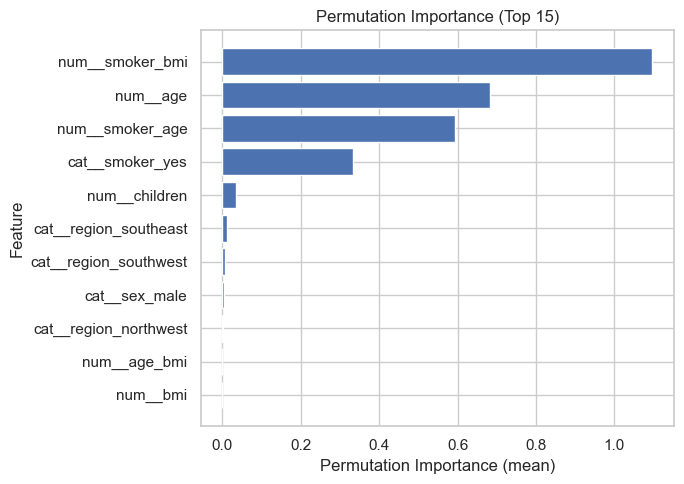

In [ ]:
# --- 11) Coefficients & Permutation Importance ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance



prep = best_en_log.named_steps["prep"]
try:
    feat_names = prep.get_feature_names_out()
except Exception:
    
    num_names = np.array(num_cols)
    
    cat_names = prep.named_transformers_["cat"].get_feature_names_out(cat_cols)
    feat_names = np.concatenate([num_names, cat_names])

# 2) 

est = best_en_log.named_steps["model"]
coefs = est.coef_  # شکل: (n_features,)

coef_df = (pd.DataFrame({"feature": feat_names, "coef": coefs})
             .sort_values("coef", key=lambda s: s.abs(), ascending=False))

print("\nTop coefficients (by |coef|):")
print(coef_df.head(15))

# 3) Permutation Importance


X_test_pre = prep.transform(X_test)

perm = permutation_importance(
    estimator=est,
    X=X_test_pre,
    y=y_test_log,                     #
    n_repeats=20,
    random_state=RANDOM_STATE,
    scoring="neg_mean_squared_error"  # "r2" / "neg_root_mean_squared_error"
)

imp_df = (pd.DataFrame({
            "feature": feat_names,
            "importance": perm.importances_mean
         })
         .sort_values("importance", ascending=False))

print("\nTop permutation importances:")
print(imp_df.head(15))

# 

topk = 15
plt.figure(figsize=(7, 5))
plt.barh(imp_df.head(topk)["feature"][::-1],
         imp_df.head(topk)["importance"][::-1])
plt.xlabel("Permutation Importance (mean)")
plt.ylabel("Feature")
plt.title("Permutation Importance (Top 15)")
plt.tight_layout()
plt.show()


In [16]:
# --- 12) Compact Summary ---
print("\n=== Compact Summary ===")
print(f"Engineered interactions used: {eng_num}")
print(f"Normality p-value: {p_norm:.3g} | Breusch–Pagan p-value: {bp_p:.3g}")
rmse_raw, mae_raw, r2_raw, mp_raw, rl_raw = report_metrics("ElasticNet-RAW", y_test, pred_raw)
rmse_log, mae_log, r2_log, mp_log, rl_log = report_metrics("ElasticNet-LOG(back-trans)", y_test, pred_log_back)
print("=> Selected best for diagnostics:", "LOG model" if rmse_log <= rmse_raw else "RAW model")


=== Compact Summary ===
Engineered interactions used: ['smoker_age', 'smoker_bmi', 'age_bmi']
Normality p-value: 1.1e-15 | Breusch–Pagan p-value: 5.88e-12
[ElasticNet-RAW] RMSE: 4564.22 | MAE: 2761.91 | R²: 0.866 | MAPE: 29.28% | RMSLE: 0.3938
[ElasticNet-LOG(back-trans)] RMSE: 5592.85 | MAE: 2639.72 | R²: 0.799 | MAPE: 18.39% | RMSLE: 0.3640
=> Selected best for diagnostics: RAW model
